In [1]:
from gensim.models import Word2Vec
import pandas as pd
import numpy as np
import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict


In [2]:
df = pd.read_csv('docs.csv').sample(frac=1).reset_index(drop=True)
df['date'] = df['rated'].apply(lambda x: datetime.datetime.strptime(x[:19],"%Y-%m-%d %H:%M:%S"))
df = df[df['date'] > datetime.datetime(2018,6,1,0,0,0)].reset_index(drop=True)
print(df.shape)
y = df['relevant']
df.head()

docs = df['content']

(1984, 13)


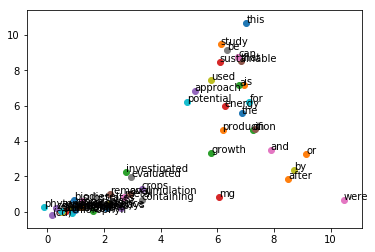

In [45]:
model = Word2Vec([[w.lower() for w in x.split()] for x in docs], size=2, window=5, min_count=1, workers=4)
import matplotlib.pyplot as plt
for i,w in enumerate(model.wv.vocab):
    x,y = model.wv[w]
    plt.scatter(x,y)
    plt.text(x,y,w)
    
    if i > 50:
        break
    


In [58]:
model = Word2Vec.load("w2v/sus_w2v.model")

Word2Vec(vocab=684020, size=300, alpha=0.025)


array([ 1.8908132 ,  0.97246516, -1.3330724 ,  0.7506126 , -1.7015477 ,
       -0.33376056,  1.1447166 ,  2.79707   ,  1.2046484 ,  1.1471866 ,
       -2.3255153 ,  0.0806137 ,  2.9256444 ,  0.83760995, -0.16738194,
        1.3906279 , -0.65346134, -0.7653233 ,  2.2709796 ,  1.0844874 ,
       -2.449367  , -0.5887824 ,  0.05965465, -3.0029342 ,  2.0470219 ,
        0.33227682,  2.3235235 , -1.0144359 , -0.55263263, -1.1810174 ,
        2.8338206 ,  1.9490793 , -1.2761811 , -0.41961262,  0.21589878,
        0.35407326,  1.0956063 , -0.03769457,  0.82032245, -0.0985295 ,
       -0.24578814, -1.5400982 , -0.10989251, -1.3270725 , -0.289774  ,
       -2.4586692 , -0.68334335, -0.5908674 ,  1.120264  , -2.4217434 ,
        1.8670921 , -0.6816702 ,  3.1204858 ,  0.994783  , -0.21949635,
       -0.71781194,  0.16998917,  0.66752476,  0.08248112,  3.4736545 ,
       -0.6819307 ,  0.07444225, -3.188447  ,  1.0385233 , -0.499127  ,
        0.84797275, -3.2439508 , -1.4635332 , -1.7479974 ,  1.40

In [59]:
print(model)
model.wv["sustainable"][:2]

Word2Vec(vocab=684020, size=300, alpha=0.025)


array([1.8908132 , 0.97246516], dtype=float32)

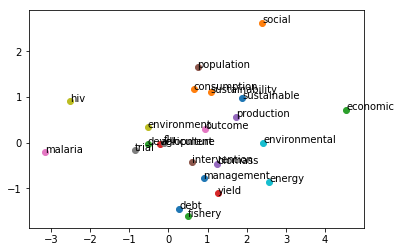

In [60]:
words = ["sustainable", "sustainability", "development", "agriculture",
        "biomass", "intervention", "malaria", "flu","hiv","energy","management","consumption",
         "fishery", "yield", "production","population", "outcome","trial","environment","environmental",
         "debt", "social", "economic"
        ]

for w in words:
    try:
        x,y = model.wv[w][:2]
    except:
        print(w)
        continue
    plt.scatter(x,y)
    plt.text(x,y,w)   
    
## Inflections and ngrams

In [50]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec.items())

    def fit(self, X):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

w2v = dict(zip(model.wv.index2word, model.wv.vectors))
vec = TfidfEmbeddingVectorizer(w2v)

In [62]:
vec.fit(df['content'])
X = vec.transform(df['content'])



AttributeError: 'numpy.ndarray' object has no attribute 'dense'

In [65]:
X

array([[ 0.02195996, -1.1846529 ,  0.84404355, ..., -0.961963  ,
         0.12974343,  0.81803465],
       [ 0.04582118, -1.1408525 ,  0.85131735, ..., -0.9504601 ,
         0.15058011,  0.8000281 ],
       [ 0.00651851, -1.1382903 ,  0.7362993 , ..., -0.97113746,
         0.2006266 ,  0.77036387],
       ...,
       [ 0.01939647, -1.1105875 ,  0.7511896 , ..., -0.9801683 ,
         0.20826483,  0.82544315],
       [ 0.05280499, -1.0387332 ,  0.8052048 , ..., -0.9303967 ,
         0.16628985,  0.8252266 ],
       [-0.00150165, -1.1240479 ,  0.7978758 , ..., -0.9739831 ,
         0.21009424,  0.77027285]], dtype=float32)

In [52]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

In [53]:
import numpy as np
import sklearn.model_selection
X_train, X_test, y_train, y_test = \
        sklearn.model_selection.train_test_split(X, df['relevant'], random_state=1)

In [54]:
X_train.shape

y_train.shape

(1488,)

In [56]:
from keras.optimizers import SGD
opt = SGD(lr=0.1)

model = Sequential()
model.add(Dense(128, input_dim=300, activation='softmax'))
model.add(Dense(1, activation='sigmoid'))
# compile the model
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())
# fit the model
model.fit(X_train, y_train, epochs=50, verbose=0, validation_data=(X_test, y_test))
# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: {:.2%}'.format(accuracy))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 128)               38528     
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 129       
Total params: 38,657
Trainable params: 38,657
Non-trainable params: 0
_________________________________________________________________
None
Accuracy: 78.83%


In [134]:
MAX_NB_WORDS = 10000
MAX_SEQUENCE_LENGTH = 500
VALIDATION_SPLIT = 0.2

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Activation, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.initializers import Constant

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df['content'])
sequences = tokenizer.texts_to_sequences(df['content'])

print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(df['relevant']))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]



Found 22151 unique tokens.
Shape of data tensor: (1984, 500)
Shape of label tensor: (1984, 2)


In [115]:
embeddings_index = {}
for w in model.wv.vocab:
    coefs = np.asarray(model.wv[w], dtype='float32')
    embeddings_index[w] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 684020 word vectors.


In [116]:
EMBEDDING_DIM = model.wv.vector_size
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [117]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [129]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
#x = MaxPooling1D(35)(x)  # global max pooling
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(2, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

# happy learning!
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=15, batch_size=128)


Train on 1588 samples, validate on 396 samples
Epoch 1/15
1588/1588 [==============================] - 8s 5ms/step - loss: 1.5407 - acc: 0.7084 - val_loss: 0.5800 - val_acc: 0.7753
Epoch 2/15
1588/1588 [==============================] - 7s 5ms/step - loss: 0.5141 - acc: 0.7809 - val_loss: 0.4729 - val_acc: 0.7753
Epoch 3/15
1588/1588 [==============================] - 7s 5ms/step - loss: 0.4785 - acc: 0.7664 - val_loss: 0.4436 - val_acc: 0.7778
Epoch 4/15
1588/1588 [==============================] - 8s 5ms/step - loss: 0.5106 - acc: 0.7651 - val_loss: 0.4096 - val_acc: 0.7753
Epoch 5/15
1588/1588 [==============================] - 8s 5ms/step - loss: 0.3706 - acc: 0.8149 - val_loss: 0.4059 - val_acc: 0.8485
Epoch 6/15
1588/1588 [==============================] - 8s 5ms/step - loss: 0.3058 - acc: 0.8602 - val_loss: 0.5898 - val_acc: 0.7879
Epoch 7/15
1588/1588 [==============================] - 28s 17ms/step - loss: 0.3123 - acc: 0.8980 - val_loss: 0.4054 - val_acc: 0.8207
Epoch 8/15
15

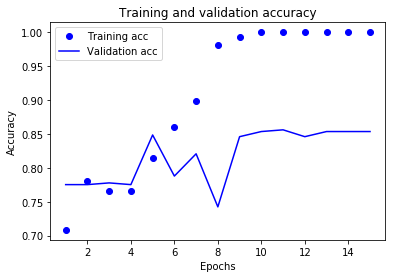

In [131]:
history_dict = history.history
history_dict.keys()

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [135]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
#x = MaxPooling1D(35)(x)  # global max pooling
x = (Dropout(0.5))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(2, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

# happy learning!
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=15, batch_size=128)


Train on 1588 samples, validate on 396 samples
Epoch 1/15
1588/1588 [==============================] - 8s 5ms/step - loss: 1.2368 - acc: 0.7179 - val_loss: 0.4999 - val_acc: 0.8157
Epoch 2/15
1588/1588 [==============================] - 7s 4ms/step - loss: 0.5395 - acc: 0.7733 - val_loss: 0.6157 - val_acc: 0.7778
Epoch 3/15
1588/1588 [==============================] - 7s 5ms/step - loss: 0.5000 - acc: 0.7683 - val_loss: 0.4156 - val_acc: 0.8157
Epoch 4/15
1588/1588 [==============================] - 8s 5ms/step - loss: 0.4464 - acc: 0.7670 - val_loss: 0.5716 - val_acc: 0.8157
Epoch 5/15
1588/1588 [==============================] - 8s 5ms/step - loss: 0.4087 - acc: 0.7997 - val_loss: 0.3383 - val_acc: 0.8535
Epoch 6/15
1588/1588 [==============================] - 8s 5ms/step - loss: 0.3831 - acc: 0.8356 - val_loss: 0.3288 - val_acc: 0.8813
Epoch 7/15
1588/1588 [==============================] - 13s 8ms/step - loss: 0.2460 - acc: 0.9011 - val_loss: 0.3517 - val_acc: 0.8510
Epoch 8/15
158

In [139]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
layer = LSTM(64)(embedded_sequences)
layer = Dense(256,name='FC1')(layer)
layer = Activation('relu')(layer)
layer = Dropout(0.5)(layer)
preds = Dense(2, activation='softmax')(layer)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

# happy learning!
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=15, batch_size=128)


Train on 1588 samples, validate on 396 samples
Epoch 1/15
1588/1588 [==============================] - 8s 5ms/step - loss: 0.5430 - acc: 0.7550 - val_loss: 0.4379 - val_acc: 0.8157
Epoch 2/15
1588/1588 [==============================] - 7s 5ms/step - loss: 0.4742 - acc: 0.7897 - val_loss: 0.3979 - val_acc: 0.8384
Epoch 3/15
1588/1588 [==============================] - 8s 5ms/step - loss: 0.4281 - acc: 0.8180 - val_loss: 0.3706 - val_acc: 0.8409
Epoch 4/15
1588/1588 [==============================] - 8s 5ms/step - loss: 0.3867 - acc: 0.8426 - val_loss: 0.3699 - val_acc: 0.8535
Epoch 5/15
1588/1588 [==============================] - 8s 5ms/step - loss: 0.3074 - acc: 0.8772 - val_loss: 0.3641 - val_acc: 0.8561
Epoch 6/15
1588/1588 [==============================] - 8s 5ms/step - loss: 0.3129 - acc: 0.8678 - val_loss: 0.3430 - val_acc: 0.8586
Epoch 7/15
1588/1588 [==============================] - 41s 26ms/step - loss: 0.2497 - acc: 0.9093 - val_loss: 0.3334 - val_acc: 0.8535
Epoch 8/15
15

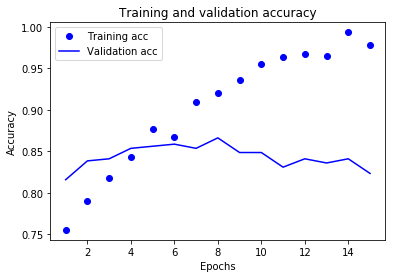

In [140]:
history_dict = history.history
history_dict.keys()

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()